In [1]:
# 각 단어를 고유 번호로 지정하기
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
# 케라스에서 기본으로 제공해주는 정수 임베딩
embedding_layer = layers.Embedding(10, 5)
# input_dim(첫번째)에 들어가는 수는 숫자 최댓값

#tf.keras.layers.Embedding(
#    input_dim, output_dim, embeddings_initializer='uniform',
#    embeddings_regularizer=None, activity_regularizer=None,
#    embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
#)

In [3]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.03765846,  0.04383794, -0.04920051, -0.00224907,  0.01705411],
       [-0.01029503, -0.02949325,  0.03244162, -0.03908483,  0.03830687],
       [ 0.02512563,  0.01263357, -0.02554301, -0.00932793,  0.01975394]],
      dtype=float32)

In [5]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteE8PH6J/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteE8PH6J/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteE8PH6J/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [7]:
# 텍스트의 특징값 중에 기타 단어를 뽑아냄
encoder = info.features['text'].encoder
encoder.subwords[:20] 

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [9]:
# 검토 기간을 표준화 시킴
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [10]:
# -- 모델 생성 --
# 모델은 기존의 'Continuous bag of words'를 따라감
# 임베딩 레이어 -> 
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.4663 - accuracy: 0.7428 - val_loss: 0.3674 - val_accuracy: 0.8400
Epoch 2/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.2755 - accuracy: 0.8864 - val_loss: 0.2480 - val_accuracy: 0.9050
Epoch 3/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.2243 - accuracy: 0.9126 - val_loss: 0.3127 - val_accuracy: 0.8350
Epoch 4/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.1944 - accuracy: 0.9241 - val_loss: 0.4013 - val_accuracy: 0.8250
Epoch 5/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.1732 - accuracy: 0.9365 - val_loss: 0.3804 - val_accuracy: 0.8150
Epoch 6/10
2500/2500 [==============================] - 19s 7ms/step - loss: 0.1540 - accuracy: 0.9436 - val_loss: 0.4421 - val_accuracy: 0.8800
Epoch 7/10
2500/2500 [==============================] - 23s 9ms/step - loss: 0.1416 - accuracy: 0.9494 - val_loss: 0.4411 - val_ac

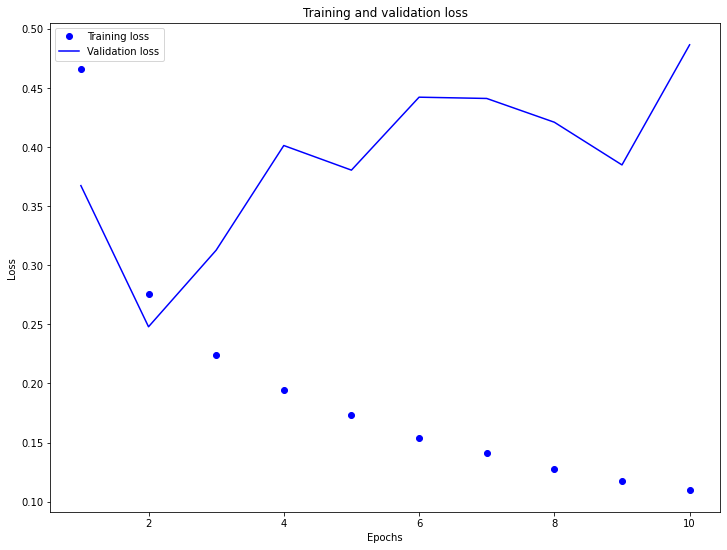

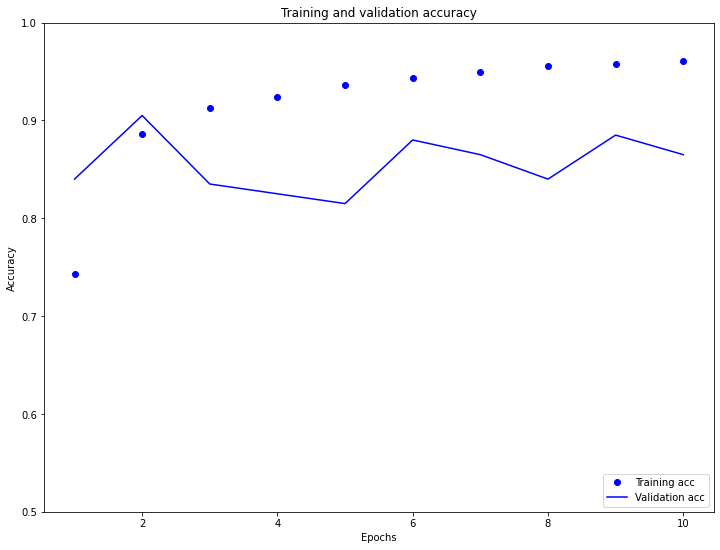

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [18]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)
